
# SCHISM procedural example

In this notebook we will use the SCHOSM grid, config and data objects to define a SCHISM workspace

### Frontmatter
Required inputs and defination of a few helper functions

In [1]:
%load_ext autoreload
%autoreload 2

# turn off warnings
import warnings
warnings.filterwarnings('ignore')


import sys
from datetime import datetime
from pathlib import Path
from rompy.core import DataBlob, TimeRange
from shutil import rmtree
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import cartopy.crs as ccrs
import pandas as pd 

import logging
logging.basicConfig(level=logging.INFO)

HERE = Path('./rompy/tests/schism')



# Define some useful functions for plotting outputs

from matplotlib.tri import Triangulation
import cartopy.feature as cfeature
#import cartopy.mpl.ticker as cticker
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()

import re
from pyproj import Proj, transform
import pytz

from scipy.spatial import KDTree
from scipy.interpolate import griddata

def schism_load(schfile):
    ''' 
    Ron: Load schism output file and parse the element/node values to create a (matplotlib) trimesh object for plotting
    
    Returns xarray dataset and trimesh object
    '''
    schout = xr.open_dataset(schfile)
    elems = np.int32(schout.SCHISM_hgrid_face_nodes[:,:-1]-1)
    # Ron: get lat/lon coordinates of nodes - weird it appears x,y are switched 
    lons = schout.SCHISM_hgrid_node_y.values
    lats = schout.SCHISM_hgrid_node_x.values
    # create trimesh object
    meshtri = Triangulation(lats, lons, triangles=elems)
    return schout, meshtri

def schism_plot(schout, meshtri,varname,varscale=[],bbox=[],time=-1,mask=True,
                vectors=False, plotmesh=False,project=False,contours=[10,30,50], 
                pscale=20,cmap=plt.cm.jet):
    ''' 
    plot output variable in xarray dataset (schout) using mesh information meshtri.
    input:
        schout: xarray dataset returned by def schism_load
        meshtri: (matplotlib) trimesh object returned by def schism_load
        varname: name of data variable in schout
        OPTIONAL:
            varscale: min/max plotting colour values (defalts to min/max)
            bbox: bounding box for plotting [minlon,minlat,maxlon,maxlat] (defalts to data bounds)
            time: time to plot (if a variable dimension), can be int (index) or datetime64-like object
            plotmesh: plot the grid mesh (elemment boundaries)
            project: use a map projection (cartopy, so that e.g. gis data can be added - this is slower
            mask: mask out parts of the SCHISM output based on a minumum depth threshold
    Returns xarray dataset and 
    We should modify this to load multiple files ... probably need assistance from DASK
    '''
    if 'time' in list(schout.dims):
        if type(time)==int : # input ts is index
            schout=schout.isel(time=time)
        else: # assume is datetime64-like object
            schout=schout.sel(time=time)
    # By default, plot depth contours 
    # ... I like depth to be z (negative)
    z=schout.depth*-1
    if np.mean(contours)>0:
        contours = np.flip(-1*np.asarray(contours))
    else:
        contours = np.asarray(contours)
    if varname=='depth' or varname=='z':
        var = z
    else:
        var=schout[varname]
    
    if len(varscale)==0: 
        vmin=var.min()
        vmax=var.max()
    else:
        vmin,vmax=varscale
    if project:
        x,y = meshtri.x,meshtri.y
        fig, ax = plt.subplots(1, 1, figsize=(pscale,pscale),
            subplot_kw={'projection': ccrs.PlateCarree()})
        if len(bbox)==4:
            ax.set_extent([bbox[0], bbox[2], bbox[1], bbox[3]], ccrs.PlateCarree())
        else:
            bbox=[x.min(),y.min(),x.max(),y.max()]
    else:
        fig, ax = plt.subplots(1, 1, figsize=(30,30))
    if plotmesh:
        ax.triplot(meshtri, color='k', alpha=0.3)
    ### MASKING ** doesnt work with tripcolor, must use tricontouf ###############################
    # mask all places in the grid where depth is greater than elev (i.e. are "dry") by threshold below
    if mask:
        # temp=var.values
        # threshold of + 0.05 seems pretty good   *** But do we want to use the minimum depth
        # defined in the SCHISM input (H0) and in output schout.minimum_depth
        # bad_idx= schout.elev.values+schout.depth.values<0.05
        bad_idx= schout.elev.values+schout.depth.values < schout.minimum_depth.values
        # new way
        mask = np.all(np.where(bad_idx[meshtri.triangles], True, False), axis=1)
        meshtri.set_mask(mask)
        
        extend='neither'
        if (var.min()<vmin) & (var.max()>vmax):
            extend='both'
        elif var.min()<vmin:
            extend='min'
        elif var.max()>vmax:
            extend='max'

        cax = ax.tricontourf(meshtri, var, cmap=cmap,levels=np.linspace(vmin, vmax, 50), extend=extend)
    #no mask#############################################################
    else:
        cax = ax.tripcolor(meshtri, var, cmap=cmap, vmin=vmin, vmax=vmax)
        # quiver variables if asked
    if vectors:
        if re.search('WWM',varname):
            vtype='waves'
        else:
            vtype='currents'
        LonI,LatI,UI,VI=schism_calculate_vectors(ax, schout, vtype=vtype)
        ax.quiver(LonI,LatI,UI,VI, color='k')

    con = ax.tricontour(meshtri, z, contours, colors='k')
    # ax.clabel(con, con.levels, inline=True, fmt='%i', fontsize=12)
    if not(project):
        ax.set_aspect('equal')
    else:
        # draw lat/lon grid lines every n degrees.
        #  n = (max(lat)-min(lat))/8
        n = (bbox[2]-bbox[0])/5
        for fac in [1,10,100]:
            nr = np.round(n*fac)/fac
            if nr>0:
                n=nr
                xticks = np.arange(np.round(bbox[0]*fac)/fac,np.round(bbox[2]*fac)/fac+n,n)
                yticks = np.arange(np.round(bbox[1]*fac)/fac,np.round(bbox[3]*fac)/fac+n,n)
                break
#        ax.set_xticks(xticks, crs=ccrs.PlateCarree()
        ax.set_xticks(xticks)
#         ax.set_xticklabels(np.arange(np.round(min(x)),np.round(max(x)),n))
#        ax.set_yticks(yticks, crs=ccrs.PlateCarree()
        ax.set_yticks(yticks)
#         ax.set_yticklabels(np.arange(np.round(min(y)),np.round(max(y)),n))
        ax.yaxis.tick_left()
        #lon_formatter = cticker.LongitudeFormatter()
        #lat_formatter = cticker.LatitudeFormatter()
        # New versions of marplotlib throw warnings on this - does it matter
	# ax.xaxis.set_major_formatter(lon_formatter)
        # ax.yaxis.set_major_formatter(lat_formatter)
	#ax.set_xticks(lon_formatter)
	#ax.set_yticks(lat_formatter)
        ax.grid(linewidth=1, color='black', alpha=0.5, linestyle='--')
        ax.add_feature(cfeature.BORDERS, linewidth=2)
    if len(bbox)==4:
        ax.set_ylim(bbox[1], bbox[3])
        ax.set_xlim(bbox[0], bbox[2])
    cbar = plt.colorbar(mappable=cax,shrink=0.5)
    cbar.set_ticks(np.round(np.linspace(vmin,vmax,5)*100)/100) 
    cbar.set_label(varname)
    
    return ax

#Nautical convention
def pol2cart2(rho, deg):
    x, y = pol2cart(rho, deg/180.*np.pi)
    return y, x

# Cartesian convention
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

def schism_calculate_vectors(ax, schout, vtype='waves', dX='auto', mask=True):
    pUTM55 = Proj('epsg:32755')
    # pWGS84 = Proj('epsg:4326')
    if vtype=='waves':
        idx=(schout.WWM_1>0.05) & (schout.elev-schout.depth<0.1)
        dp=schout.WWM_18[idx]
        # hs=schout.WWM_1[idx]
        hs=np.ones(dp.shape)
        [u,v] = pol2cart2(hs, np.mod(dp+180, 360))
    elif vtype=='elev'or re.search('curr',vtype):
        idx=np.sqrt(schout.dahv[:,0]**2+schout.dahv[:,1]**2)>0.01
        u = schout.dahv[idx,0] 
        v = schout.dahv[idx,1] #dahv has u and v components, so use index of 1 for v and index of 0 for u
    else: 
        print('*** Warning input vecter data not understood')
    x,y = pUTM55(schout.SCHISM_hgrid_node_x.values[idx],schout.SCHISM_hgrid_node_y.values[idx])
    xlim,ylim=pUTM55(ax.get_xlim(),ax.get_ylim())
    # might have to play with this - we assume a total of 100 arrows a side will be pleasing
    if dX=='auto':
        n=30
        dX = np.ceil((ylim[1]-ylim[0])/n)
    xi = np.arange(xlim[0],xlim[1]+dX,dX)
    yi = np.arange(ylim[0],ylim[1]+dX,dX)
    XI,YI = np.meshgrid(xi,yi)

    UI = griddata((x,y),u,(XI,YI),method='linear')
    VI = griddata((x,y),v,(XI,YI),method='linear')
    # Create a mask so that place with very little data are removed
    if mask:
        xbins = np.arange(xlim[0],xlim[1]+2*dX,dX)
        ybins = np.arange(ylim[0],ylim[1]+2*dX,dX)
        densityH,_,_ = np.histogram2d(x, y, bins=[xbins,ybins])
        densityH=densityH.T
        # might want to adjust this...
        idx=densityH<1
        UI[idx]=np.NaN
        VI[idx]=np.NaN
    LonI,LatI = pUTM55(XI,YI, inverse=True)

    return LonI,LatI,UI,VI


### Workspace basepath

In [2]:
workdir = Path("schism_procedural")
if workdir.exists():
    rmtree(workdir)

workdir.mkdir(exist_ok=True)

### Model Grid

In [3]:
HERE

PosixPath('rompy/tests/schism')

In [4]:
(HERE / "test_data" / "hgrid.gr3")

PosixPath('rompy/tests/schism/test_data/hgrid.gr3')

In [5]:
DataBlob??

Init signature:
DataBlob(
    *,
    model_type: Literal['data_blob', 'data_link'] = 'data_blob',
    id: str = 'data',
    source: cloudpathlib.anypath.AnyPath,
    link: bool = False,
) -> None
Source:        
class DataBlob(RompyBaseModel):
    """Data source for model ingestion.

    Generic data source for files that either need to be copied to the model directory
    or linked if `link` is set to True.
    """

    model_type: Literal["data_blob", "data_link"] = Field(
        default="data_blob",
        description="Model type discriminator",
    )
    id: str = Field(
        default="data", description="Unique identifier for this data source"
    )
    source: AnyPath = Field(
        description="URI of the data source, either a local file path or a remote uri",
    )
    link: bool = Field(
        default=False, description="Whether to create a symbolic link instead of copying the file"
    )
    _copied: str = PrivateAttr(default=None)

    def get(self, destdir: Union[st

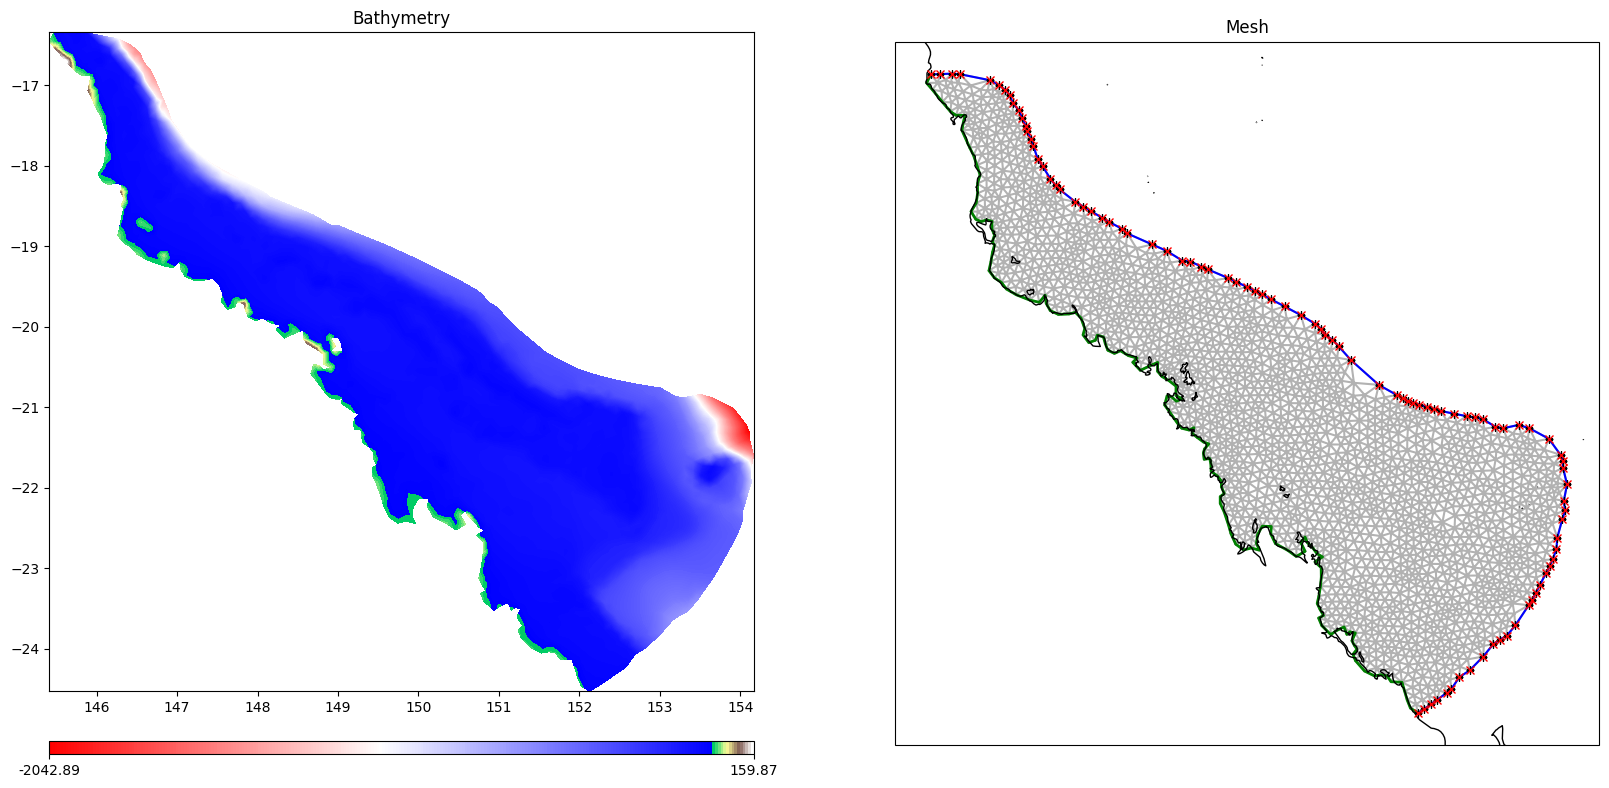

In [6]:
# Grid object

from rompy.schism import Inputs, SCHISMGrid

#SCHISMGrid?

# Medium sized grid, will run one day in about 3 minutes on 48 cores
hgrid = HERE / "test_data" / "hgrid.gr3"

# Fast running grid, will run in about 1 minute on 4 cores
#hgrid = HERE / "test_data" / "hgrid_20kmto60km_rompyschism_testing.gr3"

grid=SCHISMGrid(
    hgrid=DataBlob(id="hgrid", source=hgrid),
    drag=1,
)

grid.plot_hgrid()

In [7]:
workdir

PosixPath('schism_procedural')

In [8]:
grid.get(workdir)
list(workdir.glob('*'))

INFO:rompy.schism.grid:Generated albedo with constant value of 0.15
INFO:rompy.schism.grid:Generated diffmin with constant value of 1e-06
INFO:rompy.schism.grid:Generated diffmax with constant value of 1.0
INFO:rompy.schism.grid:Generated watertype with constant value of 1.0
INFO:rompy.schism.grid:Generated windrot_geo2proj with constant value of 0.0
INFO:rompy.schism.grid:Generated drag with constant value of 1.0
INFO:rompy.schism.grid:Linking hgrid.gr3 to schism_procedural/hgrid.ll
INFO:rompy.schism.grid:Linking hgrid.gr3 to schism_procedural/hgrid_WWM.gr3


[PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/drag.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/hgrid_WWM.gr3'),
 PosixPath('schism_procedural/vgrid.in'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/tvd.prop')]


# Forcing data

In [9]:
# First lists import the main data classes
from rompy.schism.data import SCHISMDataSflux, SCHISMDataOcean, SCHISMDataWave, SCHISMDataTides

# Sets also import a few of the minor classes that are used in the construction of these main classes for use in this demo
from rompy.schism.data import SfluxSource, TidalDataset, SfluxAir, SCHISMDataBoundary

# And also lets import some of the core data source objects. These are data input abstractions that work in exactly the same way as 
# with the swan classes, and can be used interchangeably in each of the data classes depending on the data source. We will use a 
# bit of a mix here for illustration purposes.
from rompy.core.data import DataBlob, SourceFile, SourceDataset, SourceIntake, SourceDatamesh
from rompy.core.boundary import SourceWavespectra

### Sflux Data

In [10]:
from rompy.schism.namelists import Sflux_Inputs
# SCHISMDataSflux??
# SfluxSource??
# Sflux_Inputs??



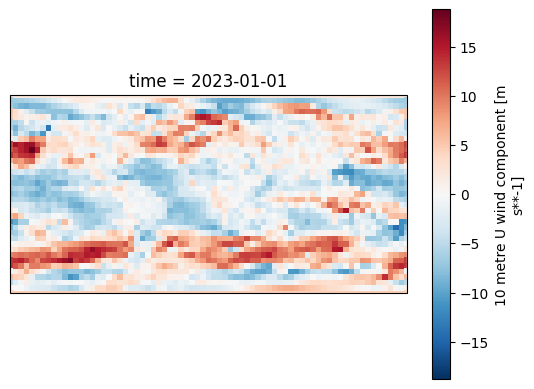

In [11]:
import intake
cat = intake.open_catalog(HERE / ".." / "data" / "catalog.yaml")
ds = cat.era5.to_dask()
ax = plt.axes(projection=ccrs.PlateCarree())
ds.u10[0].plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r")

In [12]:
# Lets have a look at an flux object. Here we will use a ERA5 dataset exposed through the intake catalog in the tests/data folder.
from rompy.core.time import TimeRange

atmos_forcing = SCHISMDataSflux(
    air_1=SfluxAir(
        id="air_1",
        source=SourceIntake(
            dataset_id="era5",
            catalog_uri=HERE / ".." / "data" / "catalog.yaml",
        ),
        filter={
            "sort": {"coords": ["latitude"]},
        },
    buffer=2
    )
)
atmos_forcing.get(destdir=workdir, grid=grid, time=TimeRange(start="2023-01-01", end="2023-01-02", dt=3600))

INFO:rompy.schism.data:Fetching air_1


In [13]:
list(workdir.glob('**/*'))



[PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/drag.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/hgrid_WWM.gr3'),
 PosixPath('schism_procedural/vgrid.in'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/tvd.prop'),
 PosixPath('schism_procedural/sflux'),
 PosixPath('schism_procedural/sflux/air_1.0001.nc'),
 PosixPath('schism_procedural/sflux/sflux_inputs.txt')]

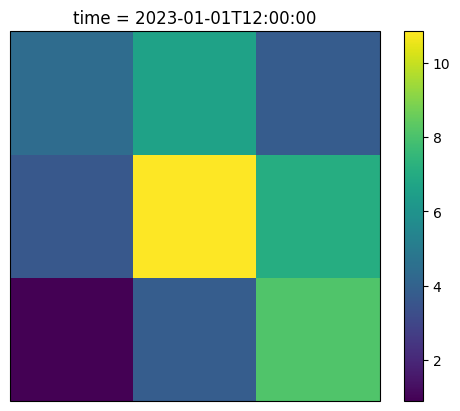

In [14]:
# Create a map
ax = plt.axes(projection=ccrs.PlateCarree())
# load the data
ds = xr.open_dataset("schism_procedural/sflux/air_1.0001.nc")
wind_speed = np.sqrt(ds.u10**2 + ds.v10**2)
# plot the data
wind_speed.isel(time=2).plot(ax=ax, transform=ccrs.PlateCarree())


### Ocean Boundary

In [15]:
#SCHISMDataOcean??

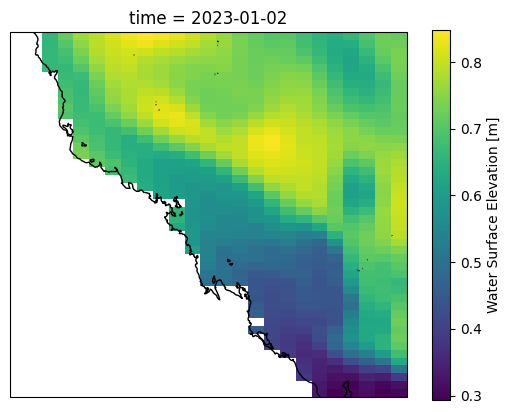

In [16]:
ds = xr.open_dataset(HERE / "test_data" / "hycom.nc")
ax = plt.axes(projection=ccrs.PlateCarree())
ds["surf_el"].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [17]:

ocean_forcing = SCHISMDataOcean(
                elev2D = SCHISMDataBoundary(
                    id="hycom",
                    source=SourceFile(
                        uri=HERE / "test_data" / "hycom.nc",
                    ),
                    variable="surf_el",
                    coords={"t": "time", "y": "ylat", "x": "xlon", "z": "depth"},
                    interpolate_missing_coastal=True,
                    ),
                )



In [18]:
ocean_forcing.get(destdir=workdir, grid=grid)
list(workdir.glob("*"))



INFO:rompy.schism.data:Fetching elev2D


[PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/drag.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/hgrid_WWM.gr3'),
 PosixPath('schism_procedural/vgrid.in'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/tvd.prop'),
 PosixPath('schism_procedural/sflux'),
 PosixPath('schism_procedural/elev2D.th.nc')]

In [19]:
dsb = xr.open_dataset('schism_procedural/elev2D.th.nc')
dsb.time[0]

<xarray.DataArray 'time' ()> Size: 8B
array('2023-01-02T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2023-01-02
Attributes:
    long_name:      Time
    standard_name:  time
    base_date:      [2023    1    2    0    0    0]

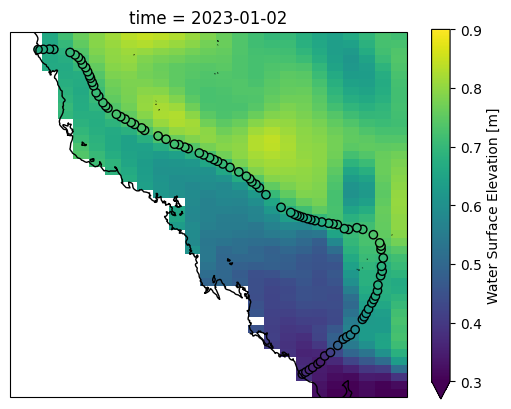

In [20]:
vmin, vmax = 0.3, 0.9
time = dsb.time[0]
ax = plt.axes(projection=ccrs.PlateCarree())
ds["surf_el"].sel(time=time).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
ax.coastlines()
values = dsb.time_series.isel(time=0)
x,y = grid.boundary_points()
ax.scatter(x, y, transform=ccrs.PlateCarree(), c=values, cmap="viridis", vmin=vmin, vmax=vmax, edgecolor="black")

# Check for nans (there shouldn't be any)
# nans = dsb.time_series.isel(time=0).isnull().squeeze()
# ax.scatter(x[nans], y[nans], transform=ccrs.PlateCarree(), c="red", edgecolor="black")

In [21]:
ocean_forcing.elev2D.ds

<xarray.Dataset> Size: 14kB
Dimensions:  (time: 3, ylat: 46, xlon: 25)
Coordinates:
  * ylat     (ylat) float64 368B -25.0 -24.8 -24.6 -24.4 ... -16.4 -16.2 -16.0
  * xlon     (xlon) float64 200B 145.0 145.4 145.8 146.2 ... 153.8 154.2 154.6
  * time     (time) datetime64[ns] 24B 2023-01-02 2023-01-03 2023-01-04
Data variables:
    surf_el  (time, ylat, xlon) float32 14kB ...
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Fleet Numerical Meteorology and Oceanography C...
    source:                    HYCOM archive file
    history:                   archv2ncdf2d
    comment:                   p-grid
    field_type:                instantaneous
    Conventions:               CF-1.6 NAVO_netcdf_v1.1

### Wave

In [22]:
# SCHISMDataWave??

In [23]:
wave_forcing = SCHISMDataWave(
        id="wavedata",
        source=SourceIntake(
            dataset_id="ausspec",
            catalog_uri=HERE / ".." / "data" / "catalog.yaml",
        ),
        coords={'x': "lon", 'y': "lat"},
)


<GeoAxes: >

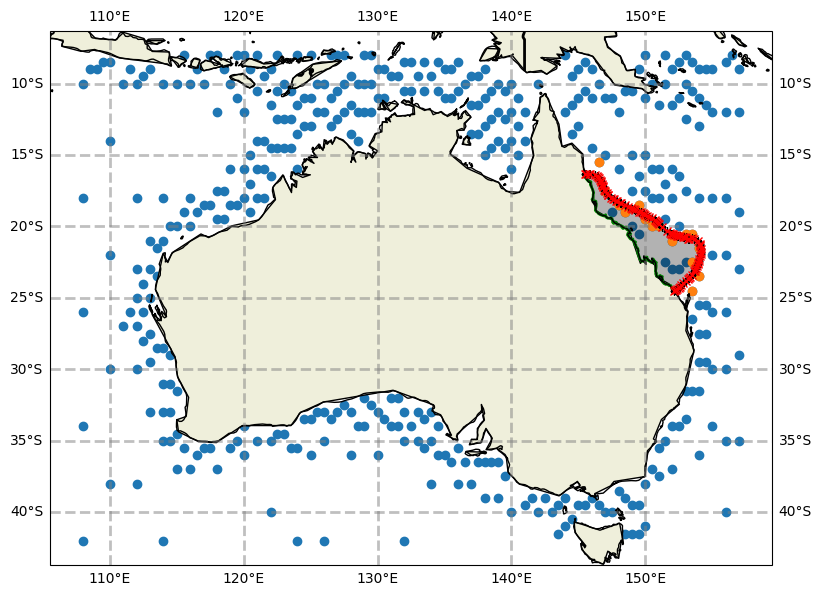

In [24]:
ax = wave_forcing.plot(model_grid=grid)
wave_forcing.plot_boundary(ax=ax, grid=grid)

### Tidal data

In [25]:
# SCHISMDataTides?
# TidalDataset?

In [26]:
tidal_forcing = SCHISMDataTides(
    tidal_data=TidalDataset(
        elevations=HERE / "test_data"/ "tpxo9-test" / "h_m2s2n2.nc",
        velocities=HERE / "test_data"/ "tpxo9-test" / "u_m2s2n2.nc" 
    ),
    constituents=["M2", "S2", "N2"],
)
tidal_forcing.get(
    destdir=workdir,
    grid=grid,
    time=TimeRange(start="2023-01-01", end="2023-01-02", dt=3600),
)



INFO:rompy.schism.data:Generating tides
INFO:pyschism.forcing.bctides.bctides:Processing boundary 1:
INFO:pyschism.forcing.bctides.bctides:Elevation type: 5
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for elevation constituent M2.
INFO:pyschism.forcing.bctides.tpxo:h_file is rompy/tests/schism/test_data/tpxo9-test/h_m2s2n2.nc
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for elevation constituent S2.
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for elevation constituent N2.
INFO:pyschism.forcing.bctides.bctides:Velocity type: 3
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for velocity constituent M2.
INFO:pyschism.forcing.bctides.tpxo:u_file is rompy/tests/schism/test_data/tpxo9-test/u_m2s2n2.nc
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for velocity constituent S2.
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for velocity constituent N2.
INFO:pyschism.forcing.bctides.bctides:Temperature type: 0
INFO:pyschism.forcing.bctides.bctides:Salinity type: 0
INFO:pysch

# Full config object

In [27]:

# Instantiate a config object

from rompy.schism import SchismCSIROConfig
from rompy.schism.data import SCHISMData
from pydantic import ValidationError
try:
    config=SchismCSIROConfig(
        grid=grid,
        data=SCHISMData(
            atmos=atmos_forcing, 
            ocean=ocean_forcing, 
            wave=wave_forcing, 
            tides=tidal_forcing
            ),
    )
except ValidationError as e:
    print(e)

1 validation error for SchismCSIROConfig
  Value error, manning.gr3 must be specified when nchi=-1 [type=value_error, input_value={'grid': SCHISMGrid([145....], sobc=[1], relax=[]))}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.7/v/value_error


In [28]:
# That gives us an expected error due to teh fact that we have a validator checking required inputs
# Lets fix the grid issue and try again

try:
    config=SchismCSIROConfig(
        grid=grid,
        data=SCHISMData(
            atmos=atmos_forcing, 
            ocean=ocean_forcing, 
            wave=wave_forcing, 
            tides=tidal_forcing
            ),
    )
except ValidationError as e:
    print(e)


# Again we get a validation error, the hgrid_WWM is missing. Lets add it and try again

grid=SCHISMGrid(
    hgrid=DataBlob(id="hgrid", source=hgrid),
    manning=1,
)
config=SchismCSIROConfig(
    grid=grid,
    mesbf=1,
    fricc=0.067,
    data=SCHISMData(
        atmos=atmos_forcing, 
        ocean=ocean_forcing, 
        wave=wave_forcing, 
        tides=tidal_forcing
        ),
)


1 validation error for SchismCSIROConfig
  Value error, manning.gr3 must be specified when nchi=-1 [type=value_error, input_value={'grid': SCHISMGrid([145....], sobc=[1], relax=[]))}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.7/v/value_error


# Model Run

Note  that most fields are optional, this eample using defaults values.


### Generate workspace


In [30]:
workdir

PosixPath('schism_procedural')

In [31]:
# having trouble using the workdir directory due to filesystem busy issues

In [32]:
#workdir = Path('schism_procedural2')

In [29]:
%pdb

Automatic pdb calling has been turned ON


In [34]:
#if workdir.exists():
#    rmtree(workdir)

#workdir.mkdir(exist_ok=True)

from rompy.model import ModelRun
from rompy.schism import SchismCSIROConfig

run = ModelRun(
    run_id="test_schism",
    period=TimeRange(start=datetime(2023, 1, 1, 0), end=datetime(2023, 1, 1, 12), interval="1h"),
    output_dir=str(workdir),
    config=config
)

rundir = run()


INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: test_schism
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-01 12:00:00
	Duration: 12:00:00
	Interval: 1:00:00
	Include End: True

output_dir: schism_procedural
config: <class 'rompy.schism.config.SchismCSIROConfig'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in schism_procedural
INFO:rompy.schism.grid:Generated albedo with constant value of 0.15
INFO:rompy.schism.grid:Generated diffmin with constant value of 1e-06
INFO:rompy.schism.grid:Generated diffmax with constant value of 1.0
INFO:rompy.schism.grid:Generated watertype with constant value of 1.0
INFO:rompy.schism.grid:Generated windrot_geo2proj with constant value of 0.0
INFO:rompy.schism.grid:Generated manning with constant value of 1.0
INFO:rompy.schism.grid:Linking hgrid.gr3 to schism_procedural/test_schis

## Lets try that again except using a DataBlob and then a DataBlob link for wave forcing

In [43]:
wave_forcing = DataBlob(id="wavedata", source="../../tests/data/wavedata.nc")

In [44]:

grid=SCHISMGrid(
    hgrid=DataBlob(id="hgrid", source=hgrid),
    manning=1,
)
config=SchismCSIROConfig(
    grid=grid,
    mesbf=1,
    fricc=0.067,
    data=SCHISMData(
        atmos=atmos_forcing, 
        ocean=ocean_forcing, 
        wave=wave_forcing, 
        tides=tidal_forcing
        ),
)


In [45]:

from rompy.model import ModelRun
from rompy.schism import SchismCSIROConfig


In [46]:
#!rm -rf schism_procedural/2

In [47]:

run = ModelRun(
    run_id="test_schism",
    period=TimeRange(start=datetime(2023, 1, 1, 0), end=datetime(2023, 1, 1, 12), interval="1h"),
    output_dir=str(workdir / '2'),
    config=config
)

In [48]:
rundir = run()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: test_schism
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-01 12:00:00
	Duration: 12:00:00
	Interval: 1:00:00
	Include End: True

output_dir: schism_procedural/2
config: <class 'rompy.schism.config.SchismCSIROConfig'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in schism_procedural/2
INFO:rompy.schism.grid:Generated albedo with constant value of 0.15
INFO:rompy.schism.grid:Generated diffmin with constant value of 1e-06
INFO:rompy.schism.grid:Generated diffmax with constant value of 1.0
INFO:rompy.schism.grid:Generated watertype with constant value of 1.0
INFO:rompy.schism.grid:Generated windrot_geo2proj with constant value of 0.0
INFO:rompy.schism.grid:Generated manning with constant value of 1.0
INFO:rompy.schism.grid:Linking hgrid.gr3 to schism_procedural/2/test

IndexError: index 1 is out of bounds for axis 0 with size 1

> /g/data/v95/bl8867/rompyenv/lib/python3.10/site-packages/pandas/core/arrays/_mixins.py(284)__getitem__()
    282         if lib.is_integer(key):
    283             # fast-path
--> 284             result = self._ndarray[key]
    285             if self.ndim == 1:
    286                 return self._box_func(result)



ipdb>  u


> /g/data/v95/bl8867/rompyenv/lib/python3.10/site-packages/pandas/core/arrays/datetimelike.py(381)__getitem__()
    379         # but skip evaluating the Union at runtime for performance
    380         # (see https://github.com/pandas-dev/pandas/pull/44624)
--> 381         result = cast("Union[Self, DTScalarOrNaT]", super().__getitem__(key))
    382         if lib.is_scalar(result):
    383             return result



ipdb>  u


> /g/data/v95/bl8867/rompyenv/lib/python3.10/site-packages/pandas/core/indexes/base.py(5389)__getitem__()
   5387             # GH#44051 exclude bool, which would return a 2d ndarray
   5388             key = com.cast_scalar_indexer(key)
-> 5389             return getitem(key)
   5390 
   5391         if isinstance(key, slice):



ipdb>  u


> /g/data/v95/bl8867/rompyenv/lib/python3.10/site-packages/xarray/core/indexing.py(1782)__getitem__()
   1780             return indexable[indexer]
   1781 
-> 1782         result = self.array[key]
   1783 
   1784         return self._handle_result(result)



ipdb>  u


> /g/data/v95/bl8867/rompyenv/lib/python3.10/site-packages/xarray/core/indexing.py(1026)apply_indexer()
   1024         return indexable.oindex[indexer]
   1025     else:
-> 1026         return indexable[indexer]
   1027 
   1028 



ipdb>  u


> /g/data/v95/bl8867/rompyenv/lib/python3.10/site-packages/xarray/core/variable.py(800)__getitem__()
    798         indexable = as_indexable(self._data)
    799 
--> 800         data = indexing.apply_indexer(indexable, indexer)
    801 
    802         if new_order:



ipdb>  u


> /g/data/v95/bl8867/rompyenv/lib/python3.10/site-packages/xarray/core/variable.py(1033)isel()
   1031 
   1032         key = tuple(indexers.get(dim, slice(None)) for dim in self.dims)
-> 1033         return self[key]
   1034 
   1035     def squeeze(self, dim=None):



ipdb>  u


> /g/data/v95/bl8867/rompyenv/lib/python3.10/site-packages/xarray/core/dataarray.py(1508)isel()
   1506         # lists, or zero or one-dimensional np.ndarray's
   1507 
-> 1508         variable = self._variable.isel(indexers, missing_dims=missing_dims)
   1509         indexes, index_variables = isel_indexes(self.xindexes, indexers)
   1510 



ipdb>  u


> /g/data/v95/bl8867/rompyenv/lib/python3.10/site-packages/xarray/core/dataarray.py(875)__getitem__()
    873         else:
    874             # xarray-style array indexing
--> 875             return self.isel(indexers=self._item_key_to_dict(key))
    876 
    877     def __setitem__(self, key: Any, value: Any) -> None:



ipdb>  u


> /home/599/bl8867/rompy/rompy/core/data.py(413)_filter_time()
    411         end = time.end
    412         if self.coords.t in self.ds.dims:
--> 413             dt = self.ds[self.coords.t][1].values - self.ds[self.coords.t][0].values
    414             # Convert to regular timedelta64
    415             regular_timedelta = dt.astype("timedelta64[s]")



ipdb>  len(self.ds[self.coords.t])


1


ipdb>  c


### And a DataBlob symlink

In [30]:
wave_forcing = DataBlob(id="wavedata", source="../../tests/data/wavedata.nc", link=True)

In [31]:

grid=SCHISMGrid(
    hgrid=DataBlob(id="hgrid", source=hgrid),
    manning=1,
)
config=SchismCSIROConfig(
    grid=grid,
    mesbf=1,
    fricc=0.067,
    data=SCHISMData(
        atmos=atmos_forcing, 
        ocean=ocean_forcing, 
        wave=wave_forcing, 
        tides=tidal_forcing
        ),
)


In [33]:
workdir / '3'

PosixPath('schism_procedural/3')

In [32]:

from rompy.model import ModelRun
from rompy.schism import SchismCSIROConfig

run = ModelRun(
    run_id="test_schism",
    period=TimeRange(start=datetime(2023, 1, 1, 0), end=datetime(2023, 1, 1, 12), interval="1h"),
    output_dir=str(workdir / '3'),
    config=config
)

rundir = run()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: test_schism
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-01 12:00:00
	Duration: 12:00:00
	Interval: 1:00:00
	Include End: True

output_dir: schism_procedural/3
config: <class 'rompy.schism.config.SchismCSIROConfig'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in schism_procedural/3
INFO:rompy.schism.grid:Generated albedo with constant value of 0.15
INFO:rompy.schism.grid:Generated diffmin with constant value of 1e-06
INFO:rompy.schism.grid:Generated diffmax with constant value of 1.0
INFO:rompy.schism.grid:Generated watertype with constant value of 1.0
INFO:rompy.schism.grid:Generated windrot_geo2proj with constant value of 0.0
INFO:rompy.schism.grid:Generated manning with constant value of 1.0
INFO:rompy.schism.grid:Linking hgrid.gr3 to schism_procedural/3/test

### Run schism
(Note that paths to schism binaries will have to be updated)

In [32]:
# Run the model 
!cd schism_procedural/test_schism && mpirun -np 4 /source/schism/src/_VL_WWM 1 

/bin/bash: line 1: mpirun: command not found


In [ ]:
# Combine outputs
!cd schism_procedural/test_schism/outputs && /source/schism/src/Utility/Combining_Scripts/combine_output11.exe  -b 1 -e 1

### Check results

In [ ]:
list(Path(f"{rundir}/outputs").glob("*"))

In [ ]:
#load schism files
schfile=('schism_procedural/test_schism/outputs/schout_1.nc')
schout,meshtri=schism_load(schfile)
lons = schout.SCHISM_hgrid_node_y.values
lats = schout.SCHISM_hgrid_node_x.values
schout

In [ ]:

# plot gridded fields - elevation
for ix, time in enumerate(schout.time[5:8].values):
    
    #fig = plt.figure(facecolor='w', figsize=(5,4))
    ax = fig.add_subplot(111)
    ax.annotate(pd.to_datetime(time).strftime('%d-%b-%Y %H:00'), fontsize=14, 
                   xy=(lons.min()+0.0005,lats.max()-0.0002), xycoords='data')
    cax=schism_plot(schout, meshtri,'elev', bbox=[145,-25,155,-16], project=True, plotmesh=True, mask=False,
              vectors=True, varscale=(-9,9),contours=[0])
    ax.tick_params( axis = 'both', which ='major', labelsize = 24)
    
    fig.subplots_adjust(left=0.05, bottom=0.07, right=0.96, top=0.93)
    #figname = '/path_to_your_dir/elev_%02d.png'%ix
    plt.show()
    plt.close()

In [ ]:
# plot gridded fields - Hs
for ix, time in enumerate(schout.time[5:8].values):
    
    #fig = plt.figure(facecolor='w', figsize=(5,4))
    ax = fig.add_subplot(111)
    ax.annotate(pd.to_datetime(time).strftime('%d-%b-%Y %H:00'), fontsize=14, 
                   xy=(lons.min()+0.0005,lats.max()-0.0002), xycoords='data')
    cax=schism_plot(schout, meshtri,'WWM_1', bbox=[145,-25,155,-16], project=True, plotmesh=True, mask=False,
              vectors=True, varscale=(0,5),contours=[0])
    ax.tick_params( axis = 'both', which ='major', labelsize = 24)
    
    fig.subplots_adjust(left=0.05, bottom=0.07, right=0.96, top=0.93)
    #figname = '/path_to_your_dir/Hs_%02d.png'%ix
    plt.show()
    plt.close()

In [ ]:
# The full model can be dumped to a configuration file.
import yaml
# dump full model to yaml
with open('model.yaml', 'w') as f:
    yaml.dump(run.model_dump(), f)


In [ ]:
!cat model.yaml

### Running from configuration files. 
The full model dump above looks complex due to the fact that the full model state, including all default value, is written to the model.yaml file. The same model configuration can be achived in a much simpler file by simply specifying non default values. For example, the entire configuration above is specified in the demo.yaml file shown below

In [25]:
!cat demo.yaml

output_dir: schism_declaritive
period:
  start: 20230101T00
  end: 20230101T12
  interval: 3600
run_id: test_schism
config:
  model_type: schismcsiro
  mesbf: 1
  fricc: 0.067
  grid:
    grid_type: schism
    hgrid:
      id: hgrid
      model_type: data_blob
        #source: ../../tests/schism/test_data/hgrid.gr3
      source: ../../tests/schism/test_data/hgrid_20kmto60km_rompyschism_testing.gr3
    manning: 1
  data:
    data_type: schism
    atmos:
      air_1:
        source: 
          uri:  ../../tests/schism/test_data/atmos.nc
          model_type: open_dataset
        uwind_name: u10
        vwind_name: v10
        prml_name: mslp
        filter:
          sort: {coords: [latitude]}
        buffer: 5
    ocean:
      elev2D:
        buffer: 0.0
        coords:
          t: time
          x: xlon
          y: ylat
          z: depth
        source: 
          uri:  ../../tests/schism/test_data/hycom.nc
          model_type: open_dataset
        variable: surf_el
    tides:
    

In [60]:
# This can be loaded and used to instatiate the model object and run as above, e.g
import yaml
demo_config = yaml.load(open('demo.yaml', 'r'), Loader=yaml.FullLoader)
run = ModelRun(**demo_config)
run()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: test_schism
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-01 12:00:00
	Duration: 12:00:00
	Interval: None
	Include End: True

output_dir: schism_declaritive
config: <class 'rompy.schism.config.SchismCSIROConfig'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in schism_declaritive
INFO:rompy.schism.grid:Generated albedo with constant value of 0.15
INFO:rompy.schism.grid:Generated diffmin with constant value of 1e-06
INFO:rompy.schism.grid:Generated diffmax with constant value of 1.0
INFO:rompy.schism.grid:Generated watertype with constant value of 1.0
INFO:rompy.schism.grid:Generated windrot_geo2proj with constant value of 0.0
INFO:rompy.schism.grid:Generated manning with constant value of 1.0
INFO:rompy.schism.grid:Linking hgrid.gr3 to schism_declaritive/test_schis

'/source/rompy/notebooks/schism/schism_declaritive/test_schism'

In [63]:
# Alternatively, this same config can be run directly using the rompy cli
!rm -fr schism_declaritive #remove previous run
!rompy schism demo.yaml

manning is being set to a constant value, this is not recommended. For best results, please supply friction gr3 files with spatially varying values. Further options are under development.
/source/rompy/.venv/lib/python3.11/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/source/rompy/.venv/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/source/rompy/.venv/lib/python3.11/site-packages/pydantic/main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `Union[BaseConfig, SwanConfig, definition-ref, definition-re